<a href="https://colab.research.google.com/github/les67/Generative_Adversarial_Networks/blob/main/jlab_2_criticalcare_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interview Problems for Data Science Postdoc position

## Problem #2 (generative models)

The goal of this exercise is to create a generative adversarial network to reproduce the tabular data found
https://github.com/JeffersonLab/jlab_datascience_data/blob/main/eICU_age.npy. The dataset
includes the ages of critical care patients seen across intensive care units in the United States. The original
data is from the eICU Collaborative Research Database https://eicu-crd.mit.edu/about/eicu/.
To solve this problem implement a generative adversarial network (GAN) in python to produce the distribution of age for these patients. Your script must coordinate both the generator and discriminator models.
Please provide figures to illustrate this coordination and compare the distribution from the generator model
output with that of the true distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
from scipy.stats import iqr
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
import os
import time

- Load Data:

In [2]:
# Load eICU critical pacient age data
age_data = np.load('/content/drive/MyDrive/eICU_age.npy')
print('Data is of shape {} and of type {}'.format(age_data.shape,age_data.dtype))

age_data = age_data.astype(int) # Change dtype to integers
print('Data is of shape {} and of type {}'.format(age_data.shape,age_data.dtype))

Data is of shape (2520,) and of type [('age', 'i1')]
Data is of shape (2520,) and of type int64


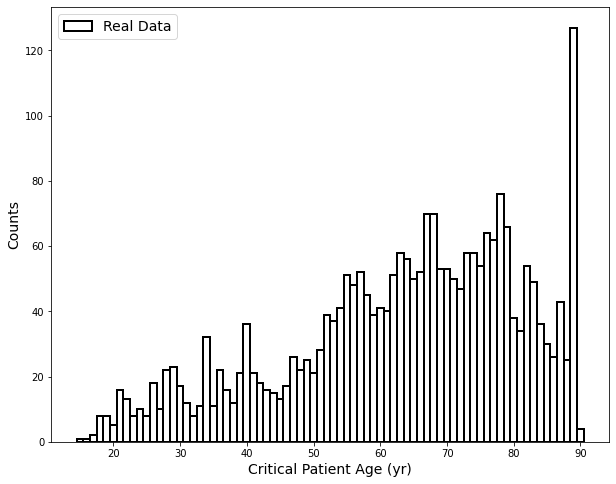

In [67]:
# Visulize real data
bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
plt.figure(figsize=(10,8))
age_data_counts, _ , _ = plt.hist(age_data,bins,facecolor='none', linewidth=2,edgecolor='k',alpha=1,label='Real Data')
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.legend(fontsize=14)
plt.show()

ages = np.arange(np.min(age_data),np.max(age_data)+1,1)

- Prepare dataset by batches
- For a batch of 200 there are 12.6 batch samples per epoch

In [4]:
BUFFER_SIZE = age_data.size # 2520 samples
BATCH_SIZE = 200

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(age_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # randomize order and cut into batches

- Define Generator and Discriminator models
- Following the architectures of https://chunliangli.github.io/docs/dltp17gan.pdf, used to model a GAN for low dimensional distributions (since ours is 1D)

In [5]:
latent_dim = 100 # dimension of noise space domain
                 # searches for explanation concluce in: this is some magic number most applications use

def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(128,activation='relu',input_shape=(latent_dim,),
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(128,activation='relu',
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(128,activation='relu',
                         kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(1))
  return model

def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(32,activation='relu',input_shape=(1,),
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(32,activation='relu',
            kernel_initializer=tf.keras.initializers.HeUniform()))
  model.add(layers.Dense(1,activation='sigmoid'))
  return model  

- Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images
- For the latent "noise" distribution we use the typical normal distrib

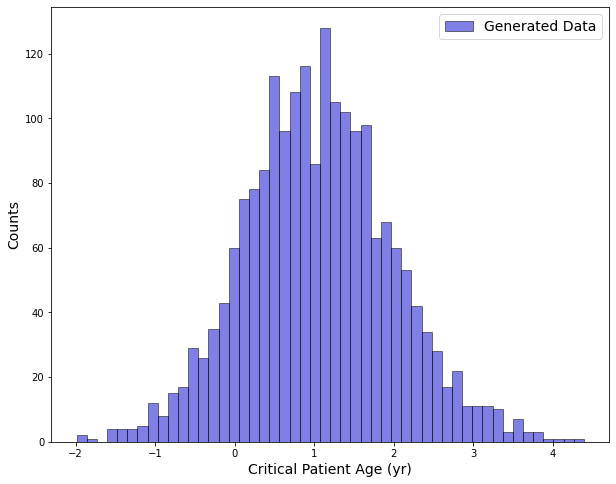

In [63]:
generator = generator_model()
discriminator = discriminator_model()

generated_samples0 = []
for i in range(2000):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples0.append(ii_generated_sample.numpy()[0][0]) 

plt.figure(figsize=(10,8))
plt.hist(generated_samples0,50,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.legend(fontsize=14)
plt.show()

- Define the losses:

In [7]:
# Use the binary cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

- Define training function based on original [GAN paper](https://arxiv.org/abs/1406.2661):
  - for $N$ of training iterations do
    - for $k$ steps do
      - Sample minibatch of $m$ noise samples ${z^{(1)},...,z^{(m)}}$ from noise prior $p_g(z)$
      - Sample minibatch of $m$ examples ${x^{(1)},...,x^{(m)}}$ from data generating distribution $p_\text{data}(x)$
      - Update the discriminator by ascending its stochastic gradient:
        $\nabla_{\theta_d}\frac{1}{m}\sum_{i=1}^m \left[ \log D\left(x^{(i)}\right) + \log \left( 1-D\left( G\left( z^{(i)}\right)\right) \right)\right)]$
    - end for
    - Sample minibatch of $m$ noise samples ${z^{(1)},...,z^{(m)}}$ from noise power $p_g(z)$
    - Update the generator by descending its stochastic gradient:
      $\nabla_\theta \frac{1}{m}\sum_{i=1}^m \log\left( 1-D\left( G\left( z^{(i)} \right) \right) \right)$ 
    - end for

- I chose to update the generator weights every 5 weight-update iterations for the discriminator
  - This is to prevent the generator loss from simply improve itself by quickly making the discriminator worse. This way we avoid updating the discriminator according to the generator's loss

In [9]:
disc_loss_hist = [] # to record loss
gen_loss_hist = []
generated_samples_progress = dict() # same generated samples every few epochs to track improvement

# Path to save training checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Training function
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print('epoch:',epoch+1)

    discrim_update_counter = 0
    for image_batch in dataset:
      noise = tf.random.normal([BATCH_SIZE, latent_dim])

      with tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(image_batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss = discriminator_loss(real_output, fake_output)
        disc_loss_hist.append(disc_loss.numpy())

      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
      discrim_update_counter += 1
      if (discrim_update_counter+1) % 9 == 0 : # Update generator after 10 updates to discriminator
        with tf.GradientTape() as gen_tape:
          generated_images = generator(noise, training=True)

          fake_output = discriminator(generated_images, training=True)

          gen_loss = generator_loss(fake_output)
          gen_loss_hist.append(gen_loss.numpy())

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))     

    # Save the model every n epochs
    if (epoch + 1) % 99 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

      # Save sample generated distribs to track progress
      ii_generated_sample = []
      for i in range(age_data.size):
        jj_noise = tf.random.normal([1,latent_dim])
        jj_generated_sample = generator(jj_noise,training=False)
        ii_generated_sample.append(jj_generated_sample.numpy()[0][0]) 
      generated_samples_progress[epoch] = ii_generated_sample

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

- Train the model:

In [ ]:
EPOCHS = 2000
train(train_dataset, EPOCHS)

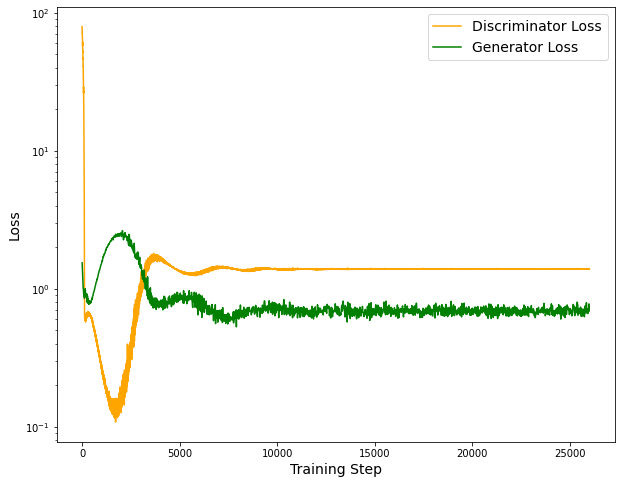

In [11]:
# Plot loss function
gen_loss_steps = np.arange(5,len(disc_loss_hist)-1,13) # generator loss was only recorded sparsely
plt.figure(figsize=(10,8))
plt.plot(disc_loss_hist,color='orange',label='Discriminator Loss')
plt.plot(gen_loss_steps,gen_loss_hist,color='green',label='Generator Loss')
plt.yscale('log')
plt.xlabel('Training Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.legend(fontsize=14)
plt.show()

- Loss shows convergence
- Generate 2520 samples from trained generator and compare to real data:

In [12]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) # point model to latest checkpoint

In [13]:
generated_samples1 = []
for i in range(age_data.size):
  ii_noise = tf.random.normal([1,latent_dim])
  ii_generated_sample = generator(ii_noise,training=False)
  generated_samples1.append(ii_generated_sample.numpy()[0][0]) 

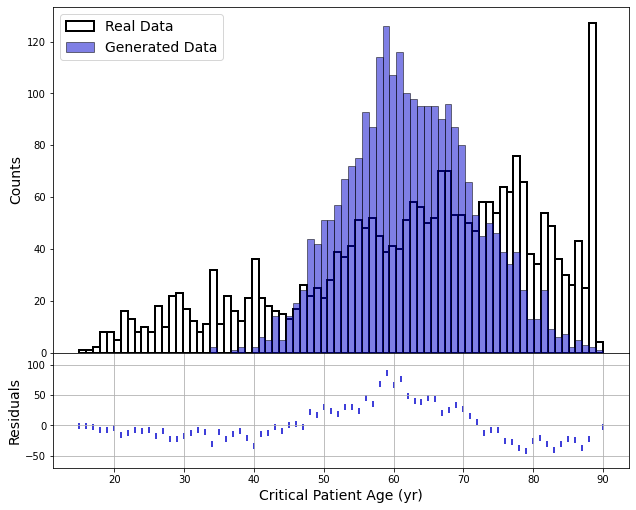

In [62]:
fig1=plt.figure(figsize=(10,8))
frame1=fig1.add_axes((.1,.3,.8,.6))
bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
a = plt.hist(age_data,bins,facecolor='none',linewidth=2, edgecolor='k',alpha=1,label='Real Data')
bin_centers = (a[1][:-1] + a[1][1:]) / 2
b = plt.hist(generated_samples1,bins,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
plt.ylabel('Counts',fontsize=14)
frame1.set_xticklabels([])
xlims = frame1.get_xlim()
plt.legend(fontsize=14)

frame2=fig1.add_axes((.1,.1,.8,.2))
res = b[0] - a[0]
plt.scatter(bin_centers,res,marker='|',color='mediumblue',alpha=1)
plt.ylim(-70,120)
plt.xlabel('Critical Patient Age (yr)',fontsize=14)
plt.ylabel('Residuals',fontsize=14)
plt.grid(True)
plt.show()

- Calculate means and stds
- Original GAN paper used Jensen-Shannon divergence to measure distribution similarity
  - JS divergence is essentially a measure of relative entropy where entropy is (information theory) the measurement of the amount of info required on average to describe that variable
  - If log base = 2, then JS is bound 0 <= JS <= 1 with 1 meaning perfect math and 0 being 

In [15]:
print('Sample mean of real data distribution: {}'.format(np.mean(age_data)))
print('Sample std of real data distribution: {}'.format(np.std(age_data)))

print('Sample mean of generated data distribution: {}'.format(np.mean(generated_samples1)))
print('Sample std of generated data distribution: {}'.format(np.std(generated_samples1)))

print('The Jensen-Shannon divergence (base 2) between target and generated distribs is: {}'.format(distance.jensenshannon(age_data,generated_samples1,base=2)))

Sample mean of real data distribution: 63.28452380952381
Sample std of real data distribution: 17.721668608381833
Sample mean of generated data distribution: 62.672271728515625
Sample std of generated data distribution: 9.178326606750488
The Jensen-Shannon divergence (base 2) between target and generated distribs is: 0.14271190183508758


- No need for further comparison as the distributions are off even by eye, although the range has improved
- The vanilla GAN implementation only manages to estimate the mean of the target distribution to ~8% error

## Posible causes & solutions:

- Problem seems to be rooted in "mode collapse"
- Mode collapse: The generator produces an especially plausible output (or sewt of outputs), then it starts producing it/them over and over again since it fools the discriminator easily. Tends to happen earlier in the training process
- The discriminator in turn learns to always reject that output (its best current strategy)
- The discriminator gets stuck in a local minimum and doesn't find the best strategy. The generator over-optimizes for this strategy and the model falls in a trap
- How to solve:
  - Use "Wasserstein Loss" instead of classic GAN loss (see [original paper](https://arxiv.org/abs/1701.07875))
  - Discriminator no longer classifies but instead predicts the probability of generated images as being real or fake. WGAN replaces the discriminator model with a critic that scores the realness or fakeness of a given image
  - Wassertein loss is based on the distance between target and generator distributions
  - Apparently, Wasserstein GANs are less vulnerable to getting stuck than minimax-based GANs, and avoid problems with vanishing gradients - (see [TF-GAN](https://github.com/tensorflow/gan) for GAN toolkit library with implementation of WGAN)

Furthermore,
- Two very good recent papers touch on this subject from an experimental viewpoint, see https://nvlpubs.nist.gov/nistpubs/jres/126/jres.126.008.pdf and https://chunliangli.github.io/docs/dltp17gan.pdf
- Both touch on the same issue: Can GANs learn simple low dimensional (1D or 2D) distributions?
- This seems to be a sparsely tested subfield of GAN performance (whereas high-dimensional spaces like image generation GANs have been widely explored)

  Takeaways:
    - GAN error as a function of training sample size shows that it is log-linear (decreasing) in sample size N and its slope depends solely on the dimension of the target distribution (see [figure  4](https://nvlpubs.nist.gov/nistpubs/jres/126/jres.126.008.pdf) for example, error is halved when going from 1D to 2D). Furthermore the error is higher for models with multiple modes
    - Two main sources of GAN error: tail underfiting (generator fails to model tails of distribution) and bridge error (generator fails to model area between modes)
    - Vanilla GANs and Wasserstein-GANs, in general, fail to learn target 1D distributions and only manage to capture the mode. This is regardless of the latent distribution (tested latent normal and uniform distributions on targets normal, uniform, cauchy, pareto); [Tables 1 and 2](https://chunliangli.github.io/docs/dltp17gan.pdf).

  Possible solutions:
    - Change latent sampling from normal distribution to stratified random sampling where the training sample is assembled from random samples drawn from each target mode (for multi-mode distribs). Relies on higher-fidelity hypothesis
    - According to above, we expect to see a decrease in error by increasing sample size. If no more data is available at eICU or otherwise, we could explore a bootstrapping approach

  Demonstrated solutions for 1D distributions:
    - Use of a maximum mean discrepancy GAN (MMD GAN) as discriminator. In these discriminators, the NNs are replaced with a two-sample t-test based kernels (see [Tables 1 and 2](https://chunliangli.github.io/docs/dltp17gan.pdf)) 

In [ ]:
# some extra code to make a movie out of generated sample progress during training

if False:
  # make samples into individual images
  generated_samples_progress[0] = generated_samples0
  keys = list(generated_samples_progress.keys())
  keys.sort()

  bins2 = np.arange(-20.5,200.5,1)
  im_counter = 0
  for ii_key in keys:
    ii_gen_samples = generated_samples_progress[ii_key]

    plt.figure(figsize=(10,8))
    bins = np.arange(np.min(age_data)-0.5,np.max(age_data)+1.5,1)
    a = plt.hist(age_data,bins,facecolor='none',linewidth=2, edgecolor='k',alpha=1,label='Real Data')
    b = plt.hist(ii_gen_samples,bins2,facecolor='mediumblue', edgecolor='k',alpha=0.5,label='Generated Data')
    plt.xlim(-10,120)
    plt.ylim(0,900)
    plt.ylabel('Counts',fontsize=14)
    plt.xlabel('Critical Patient Age (yr)',fontsize=14)
    plt.legend(fontsize=14)
    plt.title('Epoch {}'.format(ii_key),fontsize=14)
    plt.savefig('/content/drive/MyDrive/temp/{}.png'.format(im_counter), dpi=300, bbox_inches='tight') 
    plt.pause(1) 
    plt.close()

    im_counter+=1